# TF_FLOWERS classification

1. base 모델을 활용한 Transfer learning이 성공적으로 진행되었는가?	
- VGG16 등이 적절히 활용되었음
2. 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?	
- loss, accuracy 그래프 및 임의 사진 추론 결과가 제시됨
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?	
- test accuracy가 85% 이상 도달하였음

# Workflow
1. Download Dataset
2. Prep Dataset for Model Input
    - formatting, batching, scaling
    - train_batches, validation_batches, test_batches
3. Build Model
    - base model? VGG16?
    - 5 classes
4. Train Model
    - epoch? lr? optimizer, fc layer fine tuning?
    - regularization? dropout? batch normalization?
5. Eval Model
    - viz graph
    - see the pred for yourself (from val_batches or test_batches)
6. Use Model
    - input any image you want

## 1. Dataset Load
- download tf_flowers from tfds.load
- https://www.tensorflow.org/datasets/catalog/tf_flowers

In [29]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [30]:
(raw_train, raw_val, raw_test), metadata = tfds.load(
    name = 'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir = '~/aiffel/DeepLearning/flowers/',
    download = True,
    with_info = True,
    as_supervised = True,
)

In [31]:
print(raw_train)
print(raw_val)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [32]:
for image, label in raw_train.take(1):
    print(image, '\n', label)

tf.Tensor(
[[[ 93 122  30]
  [ 90 118  31]
  [ 88 118  28]
  ...
  [247  77  78]
  [253  87  87]
  [255  76  75]]

 [[ 98 125  30]
  [ 95 124  32]
  [ 96 125  32]
  ...
  [247  81  83]
  [250  86  84]
  [252  71  64]]

 [[ 98 126  26]
  [101 128  31]
  [106 132  33]
  ...
  [254  81  85]
  [254  79  76]
  [252  55  47]]

 ...

 [[ 35  51   6]
  [ 21  49   0]
  [ 30  57   6]
  ...
  [224 239  78]
  [192 208  50]
  [ 88  54  53]]

 [[ 65  73  32]
  [ 20  46   0]
  [ 22  48   0]
  ...
  [230 236  74]
  [230 246  62]
  [ 88  57  36]]

 [[ 95  97  60]
  [ 15  41   0]
  [ 23  51   3]
  ...
  [210 224  40]
  [210 241  23]
  [ 93  87  11]]], shape=(333, 500, 3), dtype=uint8) 
 tf.Tensor(2, shape=(), dtype=int64)


In [53]:
len(raw_train)

2936

In [33]:
# see the dataset

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

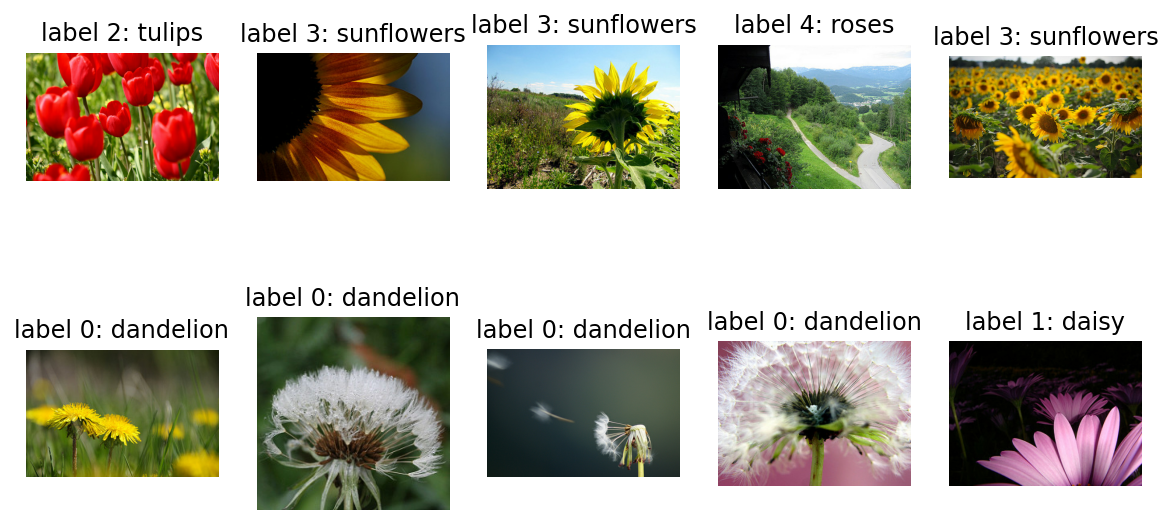

In [34]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 2. Prep Dataset for Model Input

In [35]:
# size the images

IMG_SIZE = 160

def format_size(img, label):
    img = tf.cast(img, tf.float32)
    img = (img/127.5) - 1 
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label

In [36]:
train = raw_train.map(format_size)
val = raw_val.map(format_size)
test = raw_test.map(format_size)

print(train)
print(val)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


In [37]:
# check one example

for img, label in train.take(1):
    print(img, label)

tf.Tensor(
[[[-0.27310202 -0.04880361 -0.7532981 ]
  [-0.11871476  0.03998933 -0.6735126 ]
  [-0.05732384  0.10294276 -0.63395375]
  ...
  [ 0.4047565  -0.9930438  -0.9867387 ]
  [ 0.90236366 -0.784709   -0.6929519 ]
  [ 0.969447   -0.32546413 -0.33265927]]

 [[-0.19350336  0.01655183 -0.77325827]
  [-0.0562408   0.08589926 -0.6747043 ]
  [ 0.00330427  0.12410238 -0.5987393 ]
  ...
  [ 0.40893847 -0.99143225 -1.        ]
  [ 0.9920542  -0.51565564 -0.43415135]
  [ 0.9772197  -0.40715224 -0.4229825 ]]

 [[-0.12203584  0.05088088 -0.81223196]
  [-0.04253983  0.07277885 -0.7119562 ]
  [ 0.01865049  0.12930459 -0.6060892 ]
  ...
  [ 0.51469827 -0.98769915 -0.9924173 ]
  [ 0.98466605 -0.4321078  -0.3692708 ]
  [ 0.9606158  -0.5011719  -0.5292586 ]]

 ...

 [[-0.8137714  -0.5696692  -1.        ]
  [-0.7521676  -0.5533624  -0.97913605]
  [-0.881227   -0.67199755 -1.        ]
  ...
  [-0.10628065  0.08803615 -0.45121014]
  [ 0.68773746  0.7238128  -0.5139629 ]
  [-0.03628984 -0.1862438  -0.757

In [38]:
# set batches + randomize for train data

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_batches = val.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

## 3. Build Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import utils


In [40]:
# transfer learning
## include_top=False, train the FC classifier

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

In [41]:
# Global Average Pooling

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

In [42]:
# classification layers (Dense)

dense_layer = tf.keras.layers.Dense(32, activation='relu')

pred_layer = tf.keras.layers.Dense(5, activation='softmax')

In [43]:
# see the shape per each layer

for img_batch, label_batch in train_batches.take(1):
    pass

img_batch.shape

TensorShape([32, 160, 160, 3])

In [44]:
feature_batch = base_model(img_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [45]:
feature_avg_batch = global_avg_layer(feature_batch)
feature_avg_batch.shape

TensorShape([32, 512])

In [46]:
pred_batch = pred_layer(dense_layer(feature_avg_batch))
pred_batch.shape

TensorShape([32, 5])

In [47]:
# freeze baseline model before training

base_model.trainable = False

In [48]:
# build model

model = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    dense_layer,
    pred_layer
])

In [49]:
# compile model

base_lr = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_lr)
loss = tf.keras.losses.sparse_categorical_crossentropy

model.compile(optimizer=optimizer,
             loss=loss,
             metrics=['accuracy'])

In [52]:
# pre-train pred

val_steps = 20
loss0, acc0 = model.evaluate(val_batches, steps=val_steps)

print('init loss: {:.2f}'.format(loss0), '\n', 'init acc: {:.2f}'.format(acc0))


11/20 [===============>..............] - ETA: 0s - loss: 1.7451 - accuracy: 0.1705WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 1s 36ms/step - loss: 1.7483 - accuracy: 0.1689
init loss: 1.75 
 init acc: 0.17


In [51]:
import warnings
warnings.filterwarnings('ignore')

In [55]:
EPOCHS = 20

history1 = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=val_batches)

Epoch 1/20
92/92 [==============================] - 8s 79ms/step - loss: 1.1119 - accuracy: 0.6335 - val_loss: 1.0749 - val_accuracy: 0.6567
Epoch 2/20
92/92 [==============================] - 8s 79ms/step - loss: 1.0567 - accuracy: 0.6560 - val_loss: 1.0217 - val_accuracy: 0.6703
Epoch 3/20
92/92 [==============================] - 8s 80ms/step - loss: 1.0071 - accuracy: 0.6785 - val_loss: 0.9767 - val_accuracy: 0.6757
Epoch 4/20
92/92 [==============================] - 8s 80ms/step - loss: 0.9632 - accuracy: 0.6999 - val_loss: 0.9354 - val_accuracy: 0.6866
Epoch 5/20
92/92 [==============================] - 8s 81ms/step - loss: 0.9246 - accuracy: 0.7101 - val_loss: 0.8990 - val_accuracy: 0.7030
Epoch 6/20
92/92 [==============================] - 8s 81ms/step - loss: 0.8905 - accuracy: 0.7180 - val_loss: 0.8637 - val_accuracy: 0.7084
Epoch 7/20
92/92 [==============================] - 8s 81ms/step - loss: 0.8586 - accuracy: 0.7319 - val_loss: 0.8378 - val_accuracy: 0.7084
Epoch 8/20
92

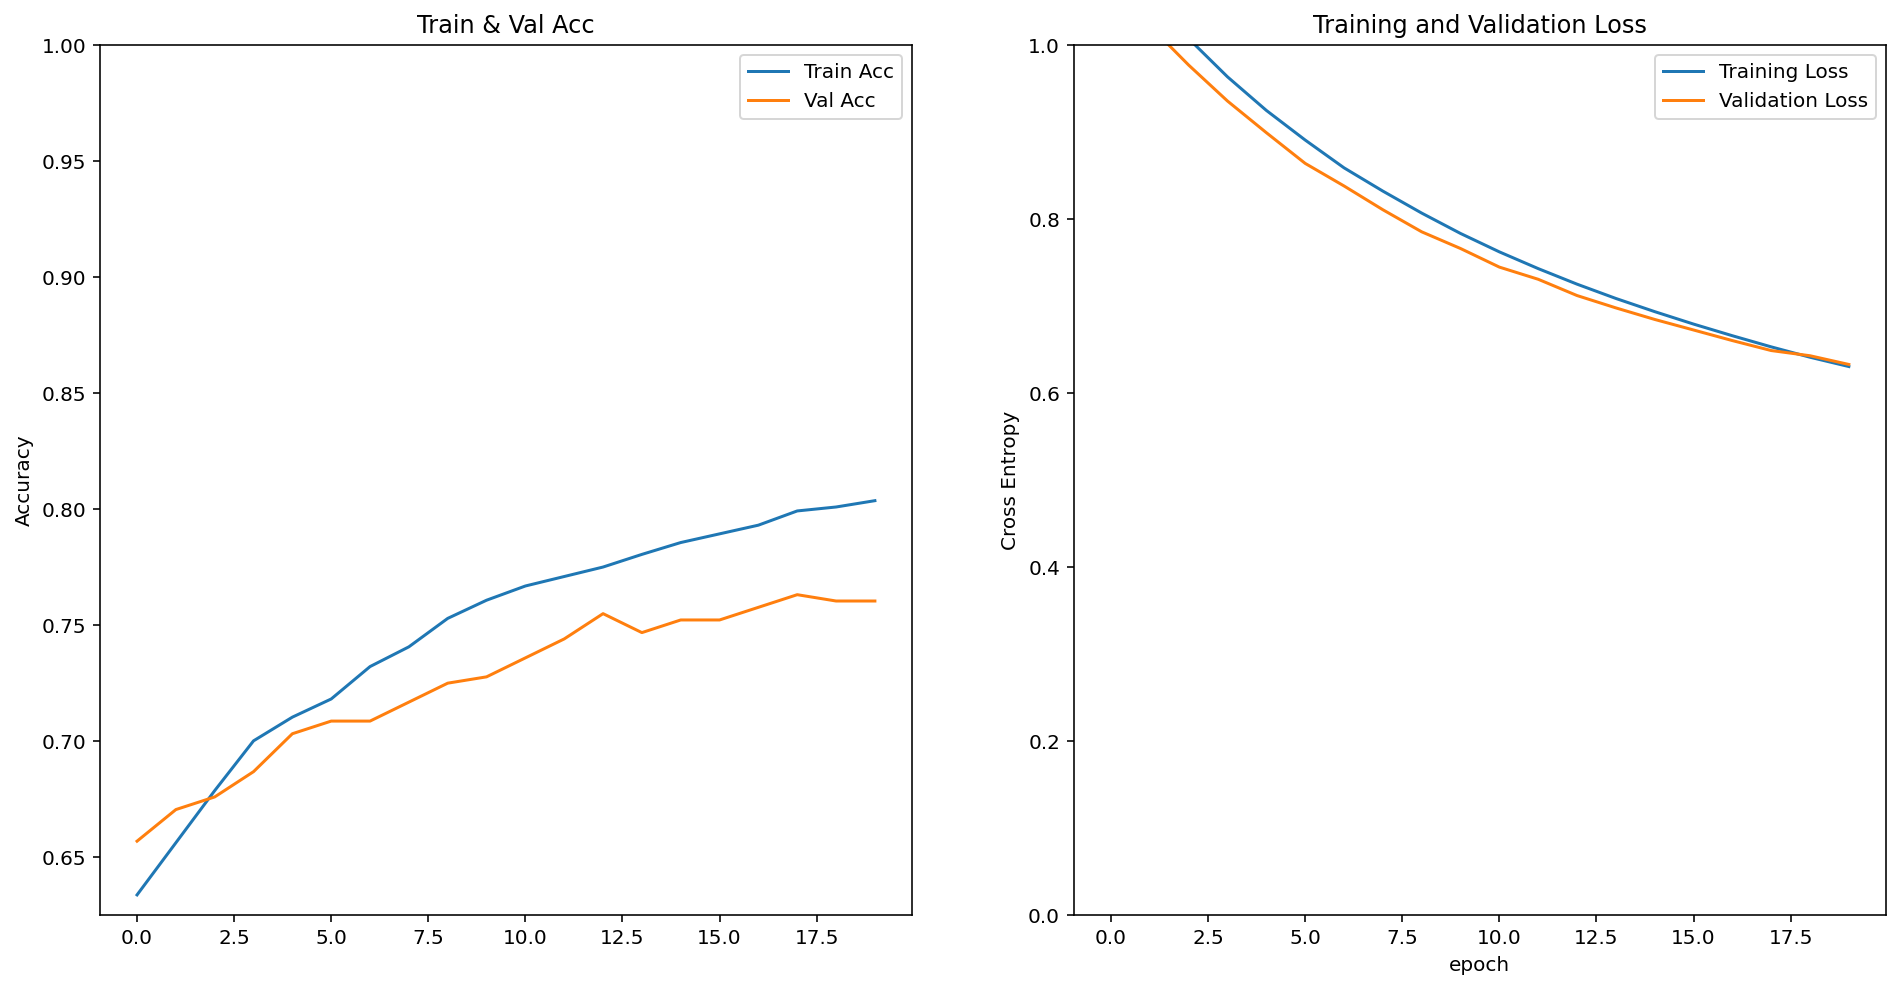

In [56]:
# viz results

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Train & Val Acc')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show();

In [59]:
# save checkpoint

import os

cp_dir = os.getenv('HOME') + '/aiffel/DeepLearning/flowers/checkpoint'
cp_file_path = os.path.join(cp_dir, 'checkpoint')

if not os.path.exists('cp_dir'):
    os.mkdir('cp_dir')
    
model.save_weights(cp_file_path)

if os.path.exists(cp_file_path):
    print('file created')

file created


# model2 - Aim for Val Acc 0.85
- history1 : 0.75
- things to try
    - epoch? lr? optimizer, fc layer fine tuning?
    - regularization? dropout? batch normalization?

In [63]:
# regularization

from tensorflow.keras.regularizers import l2

dense_layer = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001))


In [64]:
# dropout

dropout_layer = tf.keras.layers.Dropout(0.5)


In [65]:
# batch norm

batch_norm_layer = tf.keras.layers.BatchNormalization()


In [66]:
# build model2

model2 = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    dense_layer,
    batch_norm_layer,
    dropout_layer,
    Dense(5, activation='softmax')  # Assuming 5 classes for flower classification
])



In [67]:
# compile model2

lr = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.sparse_categorical_crossentropy

model2.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [68]:
EPOCHS = 20

history2 = model2.fit(train_batches,
                     epochs=EPOCHS,
                     validation_data=val_batches)

Epoch 1/20
92/92 [==============================] - 9s 80ms/step - loss: 2.1541 - accuracy: 0.2170 - val_loss: 1.6507 - val_accuracy: 0.2452
Epoch 2/20
92/92 [==============================] - 8s 78ms/step - loss: 2.0398 - accuracy: 0.2572 - val_loss: 1.6285 - val_accuracy: 0.2752
Epoch 3/20
92/92 [==============================] - 8s 79ms/step - loss: 2.0116 - accuracy: 0.2439 - val_loss: 1.6239 - val_accuracy: 0.3025
Epoch 4/20
92/92 [==============================] - 8s 79ms/step - loss: 1.9997 - accuracy: 0.2411 - val_loss: 1.6220 - val_accuracy: 0.3134
Epoch 5/20
92/92 [==============================] - 8s 79ms/step - loss: 1.9096 - accuracy: 0.2796 - val_loss: 1.6105 - val_accuracy: 0.3215
Epoch 6/20
92/92 [==============================] - 8s 80ms/step - loss: 1.9045 - accuracy: 0.2735 - val_loss: 1.5855 - val_accuracy: 0.3324
Epoch 7/20
92/92 [==============================] - 8s 80ms/step - loss: 1.8504 - accuracy: 0.2933 - val_loss: 1.5544 - val_accuracy: 0.3460
Epoch 8/20
92

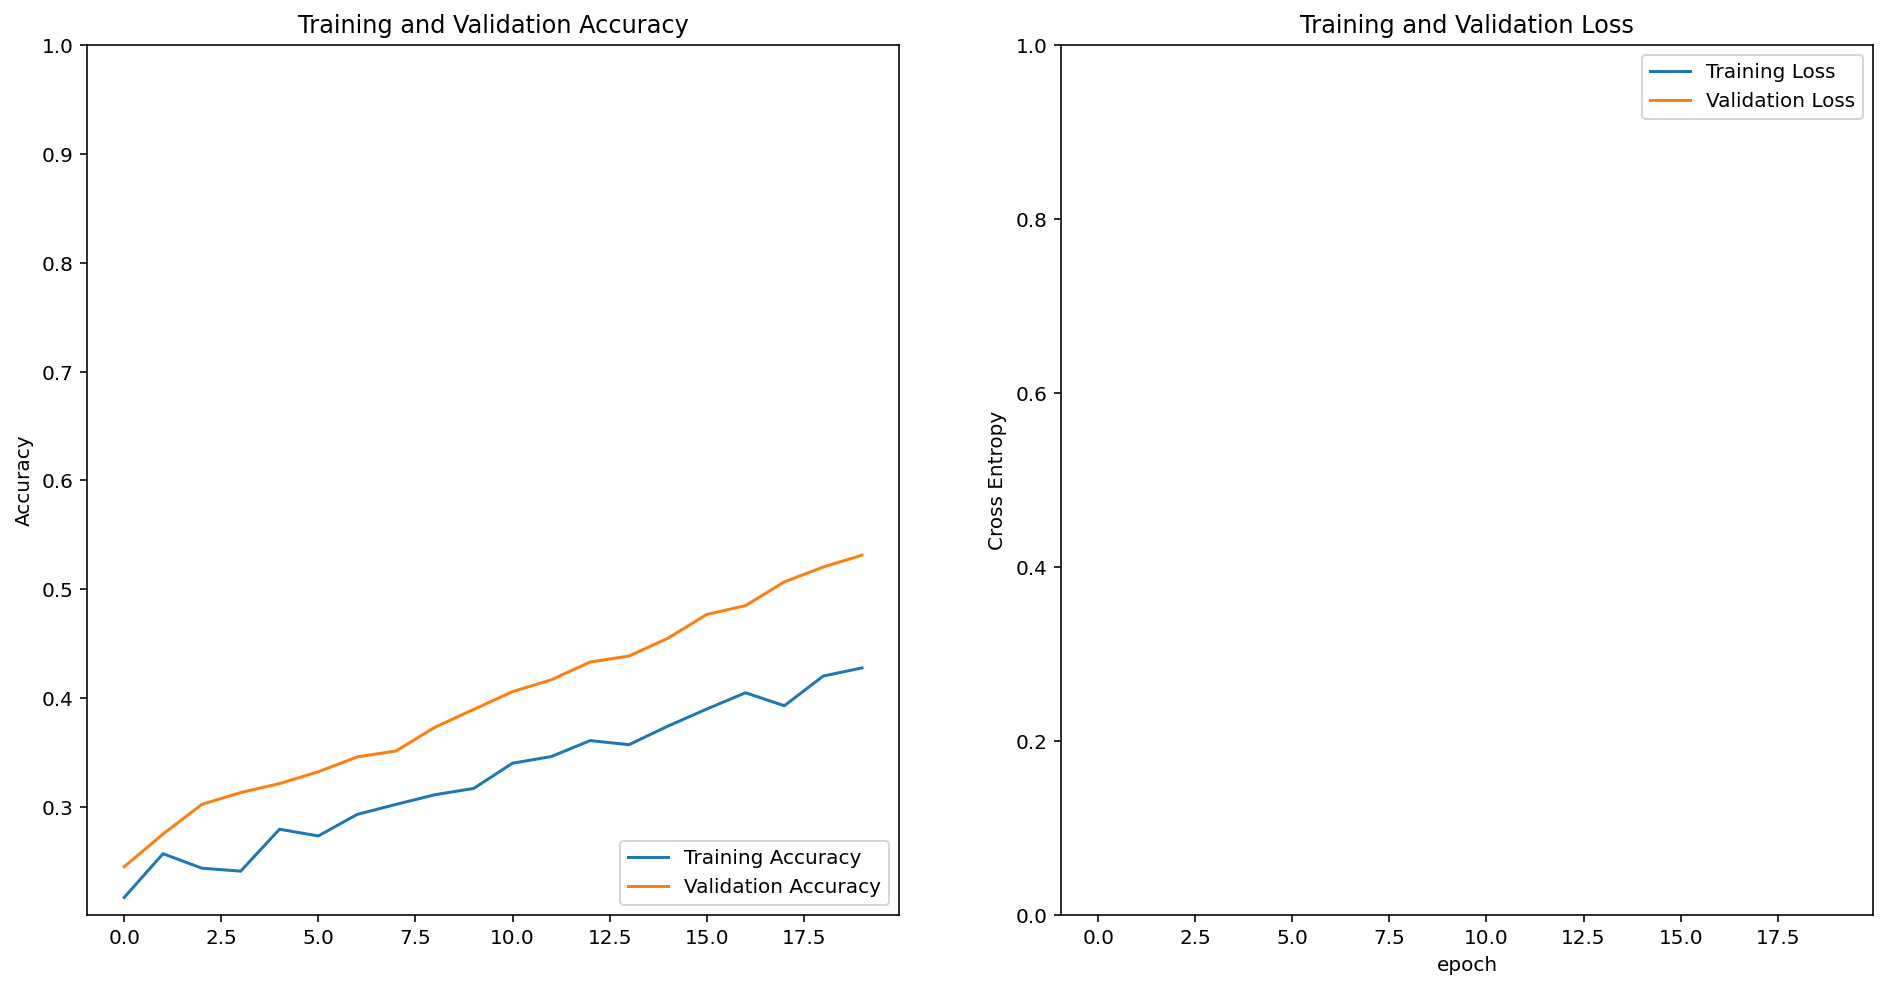

In [69]:
# viz results

acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# model3 - Data Aug, LR scheduling

In [70]:
# data aug from tfds

import tensorflow as tf

def random_flip(input_image, label):
    flipped_image = tf.image.random_flip_left_right(input_image)
    return flipped_image, label

def random_rotation(input_image, label):
    rotated_image = tf.image.rot90(input_image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return rotated_image, label

def random_zoom(input_image, label, min_zoom=0.8, max_zoom=1.0):
    zoom_factor = tf.random.uniform([], min_zoom, max_zoom)
    h, w = input_image.shape[0], input_image.shape[1]
    zoomed_h, zoomed_w = h * zoom_factor, w * zoom_factor
    zoomed_image = tf.image.resize(input_image, [zoomed_h, zoomed_w])
    zoomed_image = tf.image.resize_with_crop_or_pad(zoomed_image, h, w)
    return zoomed_image, label



In [71]:
IMG_SIZE = 160  # For example, resize images to 160x160

def format_images(input_image, label):
    image = tf.cast(input_image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Apply preprocessing and augmentation to the training dataset
train = raw_train.map(format_images).map(random_flip).map(random_rotation).map(random_zoom)
val = raw_val.map(format_images)
test = raw_test.map(format_images)

# Don't forget to batch and prefetch the datasets for performance
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_batches = val.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)


In [72]:
# lr scheduling

from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

# Example of a simple step decay function
def step_decay(epoch):
    initial_lr = 0.0001
    drop = 0.5  # Reduce learning rate by half
    epochs_drop = 10.0  # Reduce every 10 epochs
    lr = initial_lr * (drop ** (tf.floor((1+epoch)/epochs_drop)))
    return lr

# Callback for learning rate scheduling
lr_schedule_callback = LearningRateScheduler(step_decay)


In [73]:
# early stopping

from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the model's validation loss
    patience=5,         # How many epochs to wait after the last time the validation loss improved
    verbose=1,           # Log when training is stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)


In [76]:
# build model3

model3 = tf.keras.Sequential([
    base_model,
    global_avg_layer,
    dense_layer,
    Dense(64, activation='relu'),
    Dense(5, activation='softmax') 
])



In [77]:
# compile model3

lr = 0.00001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.sparse_categorical_crossentropy

model3.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [82]:

# Then, include this callback in your model's fit method
history3 = model3.fit(
    train_batches,  
    epochs=50,
    validation_data=val_batches,
    callbacks=[lr_schedule_callback, early_stopping]
)


Epoch 1/50
92/92 [==============================] - 8s 76ms/step - loss: 0.7934 - accuracy: 0.7456 - val_loss: 0.7409 - val_accuracy: 0.7166
Epoch 2/50
92/92 [==============================] - 8s 78ms/step - loss: 0.7861 - accuracy: 0.7480 - val_loss: 0.7421 - val_accuracy: 0.7112
Epoch 3/50
92/92 [==============================] - 8s 80ms/step - loss: 0.7676 - accuracy: 0.7554 - val_loss: 0.7284 - val_accuracy: 0.7221
Epoch 4/50
92/92 [==============================] - 8s 80ms/step - loss: 0.7465 - accuracy: 0.7561 - val_loss: 0.6962 - val_accuracy: 0.7330
Epoch 5/50
92/92 [==============================] - 8s 79ms/step - loss: 0.7445 - accuracy: 0.7534 - val_loss: 0.7098 - val_accuracy: 0.7384
Epoch 6/50
92/92 [==============================] - 8s 78ms/step - loss: 0.7296 - accuracy: 0.7619 - val_loss: 0.6990 - val_accuracy: 0.7384
Epoch 7/50
92/92 [==============================] - 8s 77ms/step - loss: 0.7232 - accuracy: 0.7619 - val_loss: 0.7011 - val_accuracy: 0.7302
Epoch 8/50
92

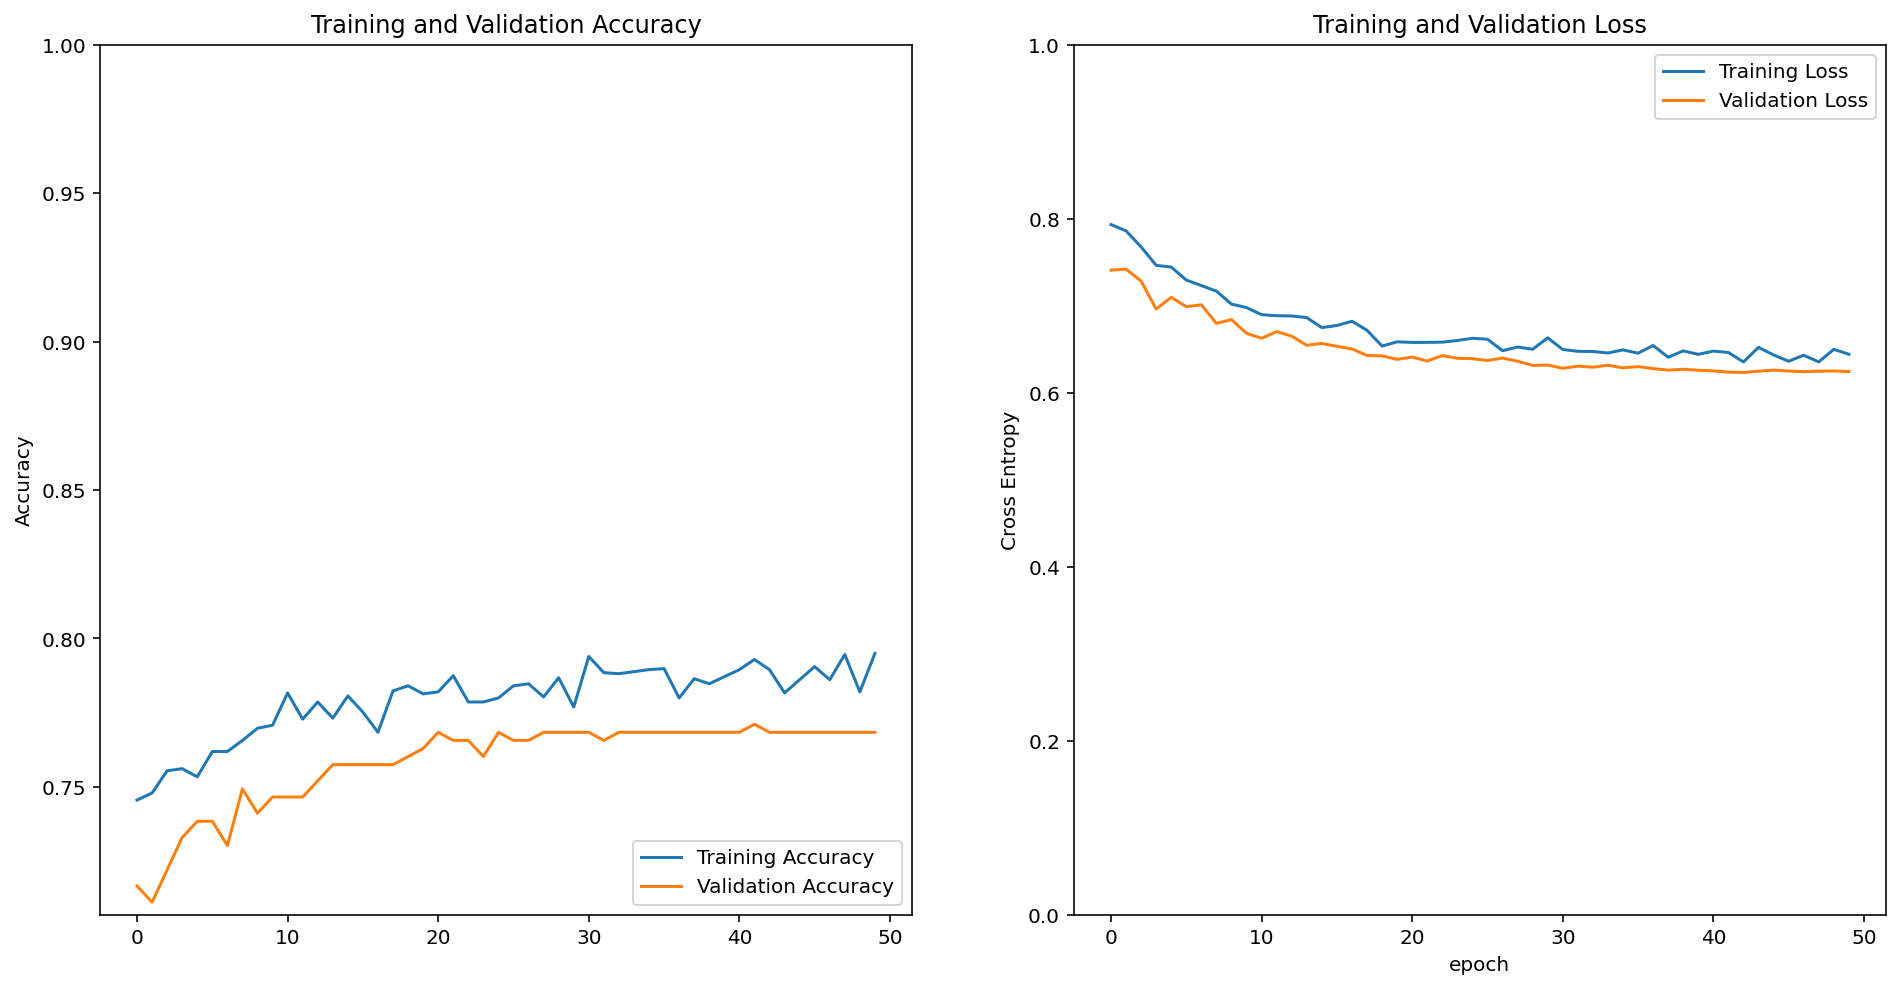

In [83]:
# viz results

acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Model Eval
- model 오리지널이 가장 val pred 가 좋았다.. 과연 test 로도?

In [80]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 1s 66ms/step - loss: 0.6481 - accuracy: 0.7657
Test Loss: 0.648076057434082
Test Accuracy: 0.7656675577163696


In [81]:
# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 1s 65ms/step - loss: 10.3011 - accuracy: 0.2943
Test Loss: 10.301125526428223
Test Accuracy: 0.29427793622016907


In [84]:
# Evaluate the model on the test set
test_loss, test_accuracy = model3.evaluate(test_batches)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 1s 64ms/step - loss: 0.6532 - accuracy: 0.7711
Test Loss: 0.6531614065170288
Test Accuracy: 0.7711171507835388


# 회고
- 이미지 스케일링은 pre-trained model 이 어떻게 스케일된 이미지로 학습했는지에 맞춰주는 게 좋다고 한다
    - 찾아봤는데 vgg 는 RGB 평균을 빼주라는데..? 별 상관 없을거란 말도 있어서 일단 원래 노드에서처럼 -1 과 1 사이로 스케일링 한다
- VGG 에서 별다른 처리 안하고 에포크만 20으로 했더니 바로 val acc 가 0.75 정도 나왔다
    - 초거대 기업이 아니면 0에서 모델을 만들 일은 없겠구나
- dropout, batch normalization 했더니 오히려 0.5로 예측력이 떨어졌다. lr 도 1/10 로 줄이고 옵티마이저도 adam 으로 바꿨다
- dense 레이어 추가해서 드롭아웃/batch norm 빼고, data aug 하고 lr scheduling + early stopping 해서 다시 돌려봤는데 베이스 모델과 큰 차이가 없었다
- test acc 가 0.005 정도 올라갔다..